In [3]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/IU.png' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(960, 720, 3)


In [8]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [9]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [4]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(960, 720, 3) (513, 384, 3) 15


네트워크에 이미지 입력

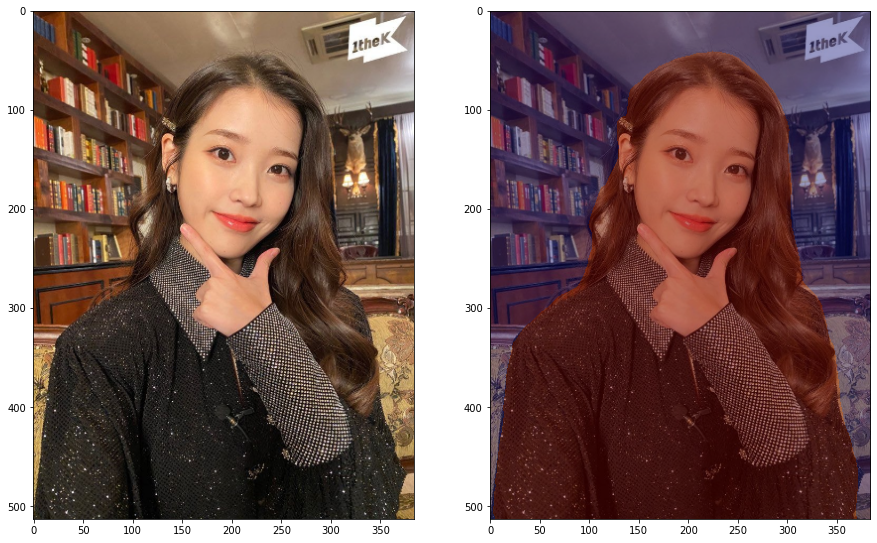

In [5]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)


plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

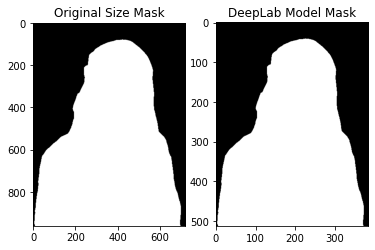

In [6]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

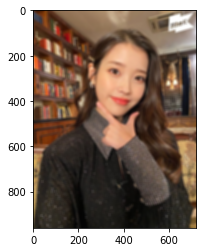

In [7]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

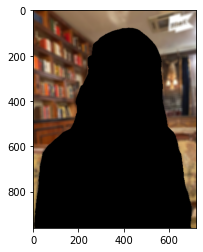

In [8]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

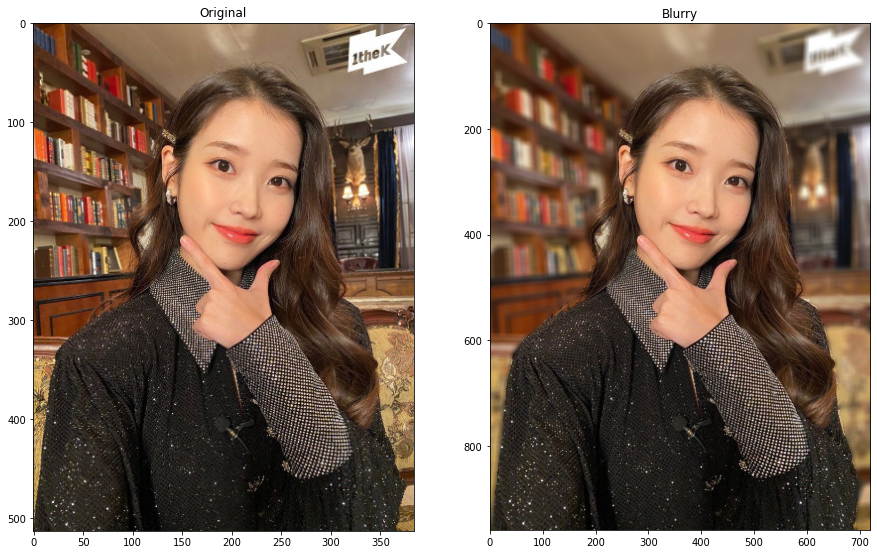

In [9]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize = (15,15))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('Blurry')

plt.show()

여러가지 사진으로 테스트를 해보기 위해 앞서 진행한 과정을 하나의 함수로 만들어보기로 했습니다  
입력값으로 원본사진과 포커싱할 객체의 유형을 받아서 아웃포커싱된 사진을 반환하는 함수 def out_focusing(img_name, img_type = 15)  
그리고 원본사진과 수정된 사진을 동시에 출력하는 함수 show_img를 만들어봅시다  

In [10]:
def out_focusing(img_name, img_type = 15) :
    #이미지 불러오기
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + img_name
    img_orig = cv2.imread(img_path) 
    
    #이미지 리사이즈, 네트워크에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    #이미지 마스크 만들기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == img_type, img_type, 0) # 예측 중 img_type만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    #결과를 다시 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    #사진 블러
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다.
    
    #마스크 적용
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    #사진 반환
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    return img_resized, img_concat

In [11]:
def show_img(img_orig, img_fixed, _figsize = (15,15)) :
    plt.figure(figsize = _figsize)

    ax = plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    ax.set_title('Original')

    ax = plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_fixed, cv2.COLOR_BGR2RGB))
    ax.set_title('Fixed')

    plt.show()

(300, 534, 3) (288, 513, 3) 15


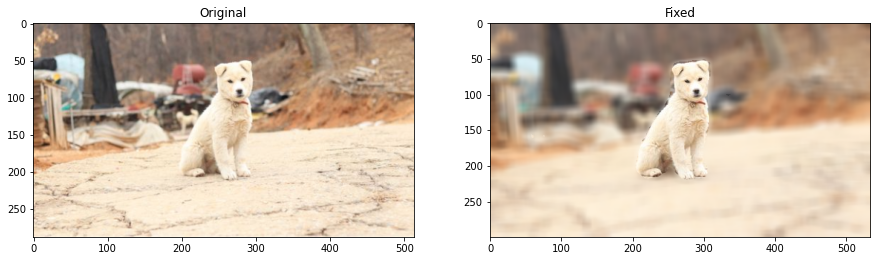

In [12]:
img_resized, img_fixed = out_focusing("Dog.jpg", img_type = 12)
show_img(img_resized, img_fixed)

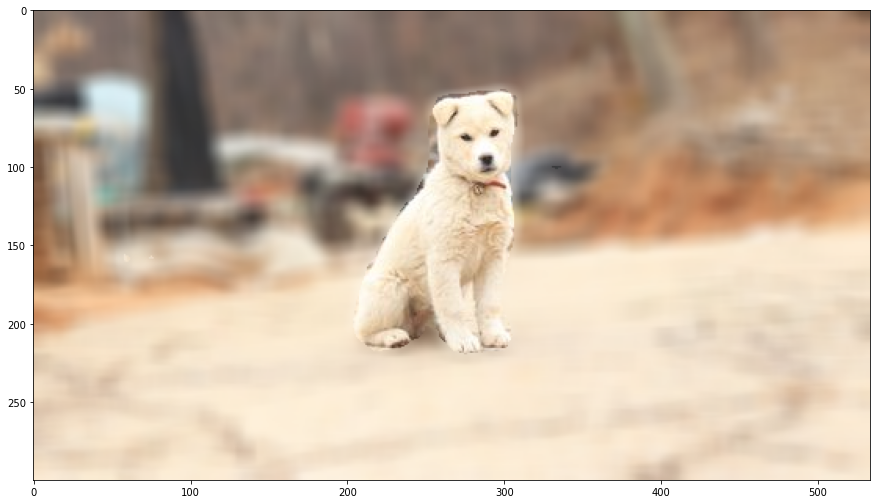

In [13]:
plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(img_fixed, cv2.COLOR_BGR2RGB))
plt.show()

강아지사진으로 테스트하니까 세그멘테이션의 한계가 더 뚜렷하게 드러납니다  
영역이 정확하지 않게 잘라진것이 보이고 사물과 배경의 깊이도 반영되지 않았네요
특히 초점을 강아지에 맞췄더라도 강아지 경계 안에서 약간 흐릿한 부분이 있어야 할 것 같습니다.

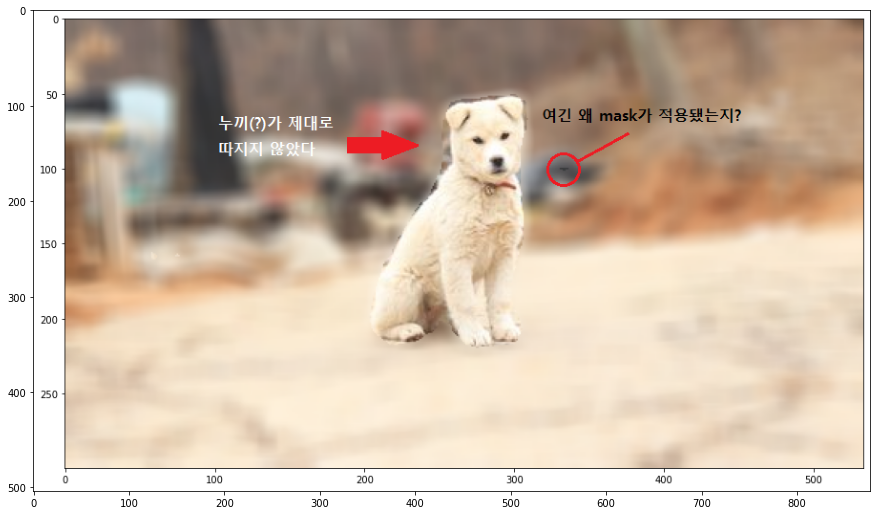

In [14]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Dog_error.png'
img_orig = cv2.imread(img_path)
plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

# 솔루션  

이미지의 경계선이 깔끔하게 따지지 않는 문제는 세그멘테이션의 정밀도를 높이면 될 일이지만  
사물과 배경의 깊이가 반영되지 않는 문제는 해결하기 어려울 것 같습니다.  
이를 해결하기 위한 솔루션 몆가지가 노드에 몆가지 정리되어 있었습니다.  
## 1. 3D Depth Camera  
첫번째는 3D깊이 카메라 기술을 이용한 해결책입니다.  
일반적인 카메라와 다르게 인간이 두 눈으로 입체감있게 보듯이 2개의 카메라를 이용해서 픽셀의 깊이를 계산합니다.  
요즘 스마트폰도 대부분 2개의 카메라를 장착해서 나오니 어플로 개발하면 보편적으로 쓰일만 할 것 같습니다.  
하지만 3D깊이 카메라 기술은 인터넷에서 다운받은 사진이나 이미 찍어놓은 사진엔 적용이 불가능하다는 단점이 있습니다.  
## 2. Depth Image  
구글에서 발표한 Struct2Depth 기법을 이용하면 한 개의 카메라로도 픽셀의 깊이를 계산할 수 있고 이미 촬영된 영상에도 적용할 수 있습니다.  
하지만 연속적인 영상에만 적용가능하기때문에 결국 노트의 아웃포커싱 메소드와 같이 적용하기는 힘들어 보입니다...  
사진에 아웃포커싱을 구현하는 어플보다는 자율주행 등의 기술에 더 유용할것 같습니다.
## 3. IR
적외선과 인공 신경망을 이용한 방식입니다, 기존 방식보다 더 효율적이고 강력하지만 적외선 카메라를 장착한 스마트폰은 흔치 않습니다  
구글의 pixel4에 적외선 카메라가 달려있다고 하는데 삼성/애플 사용자가 대부분인 우리나라 환경과는 맞지 않는군요

## 선택한 솔루션과 적용방법
위에서 소개한 3가지 방법중에 가장 보편적으로 적용할 수 있는것은 3D depth camera일것 같습니다,  
최근 나오는 대부분의 스마트폰에 카메라가 2개 이상 달려있으니 말이죠, 
우선 이미 촬영된 사진은 사진의 깊이를 반영하는 데이터가 손실된 상태니 적용이 힘들 것 같습니다.  
대신 스마트폰 카메라로 즉석에서 사진을 찍어서 합성하는 어플을 만든다고 가정하고 그 메커니즘을 작성해 보겠습니다.

스마트폰 어플로 만들어서 실시간으로 사진을 촬영하면, 스테레오 방식을 사용해 픽셀의 깊이 정보를 가져옵니다.  
그러면 깊이 정보가 반영된 사진의 이미지가 생성될 것입니다.  
그리고 위에서 생성된 mask 이미지도 있겠죠? 배경은 통째로 blur 해버려도 될것 같습니다,  
대신 mask영역 안에 있는 이미지에 대해서 픽셀의 깊이 정보를 이용해 mask에 alpha값을 차등적으로 주면 될 것 같습니다.  
최종적으로 합성된 이미지는 가장 앞에 있는 부분이 가장 뚜렷하고 가장자리 부분은 조금 흐릿한 이미지가 되겠네요

마지막으로 크로마키 이미지까지 적용해보고 마치겠습니다.

In [58]:
def chroma_key(img_name1,img_name2, img_type = 15) :
    #이미지 불러오기
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + img_name1
    img_main = cv2.imread(img_path) 
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + img_name2
    img_backGround = cv2.imread(img_path) 
    
    #이미지 리사이즈, 네트워크에 입력
    img_resized, seg_map = MODEL.run(img_main)
    print (img_main.shape, img_resized.shape, seg_map.max())
    
    #이미지 마스크 만들기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == img_type, img_type, 0) # 예측 중 img_type만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    #결과를 다시 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_main.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    #마스크 적용
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    
    #이미지 리사이즈
    img = img_backGround
    width = img_main.shape[1]
    height = img_main.shape[0]
    dim = (width, height)       
    back_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)   
    
    img_concat = np.where(img_mask_color==255, img_main, back_resized)
    
    return img_concat   

(869, 1200, 3) (371, 513, 3) 15


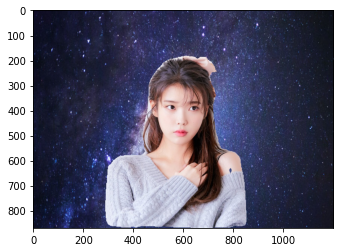

In [59]:
img_chroma = chroma_key('IU2.png','space.png')
plt.imshow(cv2.cvtColor(img_chroma, cv2.COLOR_BGR2RGB))

(960, 720, 3) (513, 384, 3) 15


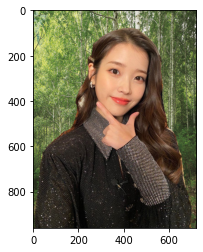

In [60]:
img_chroma = chroma_key('IU.png','forest.png')
plt.imshow(cv2.cvtColor(img_chroma, cv2.COLOR_BGR2RGB))